Needed to remove the tensorflow keras and import the "pure" keras because there were conflicts with using both

In [93]:
# TensorFlow and tf.keras

import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
from keras import layers
import keras.backend
import keras.layers
import keras.models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import numbers
import time

1.13.1


Nothing changed with the way the data is generated

In [94]:
def make_circles(grid = 11, n_data = 10):    
    max_distance = int((grid-1)/2)
    radii = np.random.randint(max_distance/4.,max_distance,size = (n_data, 2))
    radii = radii.flatten()
    distance = np.random.randint(max_distance, size = n_data)
    distances = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in distance])
    radii1 = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in radii[::2]])
    radii2 = np.array([np.multiply(np.ones(shape = (grid,grid)),y) for y in radii[1::2]])
    circle = np.zeros((n_data, grid, grid))
    circlex = np.zeros((grid, grid))
    circley = np.zeros((grid, grid))
    circlex[:][:][:] = np.arange(grid)
    circley[:][:][:] = np.transpose(circlex)
    x1 = circley - max_distance + distances/2
    x2 = circley - max_distance - distances/2
    y = circlex - max_distance
    position1 = np.sqrt(x1**2+y**2)
    position2 = np.sqrt(x2**2+y**2)
    fill1 = position1 <= radii1
    fill2 = position2 <= radii2
    p1 = np.exp((-1./2.)*(3.*position1/radii1)**2.)
    p2 = np.exp((-1./2.)*(3.*position2/radii2)**2.)
    p1 = np.where(fill1, p1, 0.0)
    p2 = np.where(fill2, p2, 0.0)
    circles = p1 + p2
    circles = circles.reshape(n_data, grid**2)
    radii = radii.reshape(n_data, 2)
    distances = distances.reshape(n_data*grid**2,1)[::grid**2]
    return circles, radii, distances
   

In [95]:
grid = 100
n_data = 500
toc = time.clock()
circleData, radiiLabels, distanceLabels = make_circles(grid, n_data)
tic = time.clock()
print(tic-toc)

1.377931769722636


In [96]:
distanceData = circleData.reshape(n_data, grid, grid, 1)

split = int(0.8*len(circleData))
train_data = distanceData[:split]
train_labels = distanceLabels[:split]
test_data = distanceData[split:]
test_labels = distanceLabels[split:]

Needed to add this input shape part so that it recognized the input as coming from an "input layer"

In [97]:
print (train_data.shape)

(400, 100, 100, 1)


In [98]:
input_shape = (100,100,1)

In [99]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [100]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    print('.', end='')
    
EPOCHS = 100

Aside from the input_shape, the model is the same

In [101]:
model_distance = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(1)
])

model_distance.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
model_distance.fit(train_data, train_labels, 
                   epochs=EPOCHS, validation_split = 0.2,  verbose=0, callbacks=[early_stop, PrintDot()])



...........................................................

In [102]:
results = model_distance.evaluate(test_data, test_labels)
print(results)

100/100 [==============================] - 0s 2ms/step
[0.2950274270027876, 0.2950274270027876, 0.41147178649902344]


### Explainability tools

In [103]:
import innvestigate
import innvestigate.utils as iutils

Taking an example image to work with

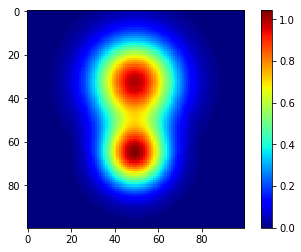

In [121]:
display = circleData[8].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
plt.grid(False)
plt.imshow(display.squeeze(), cmap = 'jet')
plt.colorbar()
plt.show()

Now for the actual analysis:

I'm going to repeat the same process with multiple LRP tools

This is the same as is done in the innvestigate introduction notebook

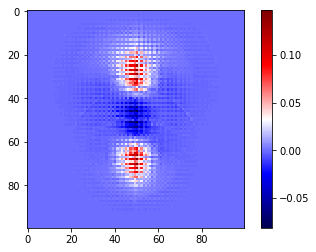

In [122]:
# Creating an analyzer
lrp_analyzer1 = innvestigate.create_analyzer("lrp.z", model_distance)

# Applying the analyzer
analysis = lrp_analyzer1.analyze(display)

# Displaying the result
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

Now with another LRP method

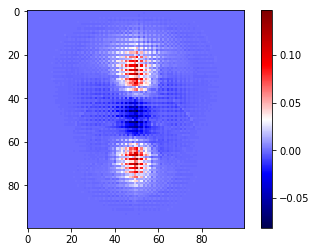

In [123]:
lrp_analyzer2 = innvestigate.create_analyzer("lrp.epsilon", model_distance)
analysis = lrp_analyzer2.analyze(display)
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

Now we will try the same for the radius example

In [107]:
circleData = circleData.reshape(n_data, grid, grid, 1)
split = int(0.8*len(circleData))
train_data_rad = circleData[:split]
train_labels_rad = radiiLabels[:split]
test_data_rad = circleData[split:]
test_labels_rad = radiiLabels[split:]

In [108]:
model_radius = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(64, activation=tf.nn.relu), 
    layers.Dense(2)
])

model_radius.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 
                                                                           'mean_absolute_error',
                                                                           'accuracy'])
model_radius.fit(train_data_rad, train_labels_rad, 
                 epochs=EPOCHS, validation_split = 0.2,  verbose=0, callbacks=[early_stop, PrintDot()])



..................................

In [109]:
results = model_radius.evaluate(test_data_rad, test_labels_rad)
print(results)

100/100 [==============================] - 0s 3ms/step
[3.6590752470493317, 3.6590752470493317, 1.0949560070037843, 0.97]


Repeat the analysis

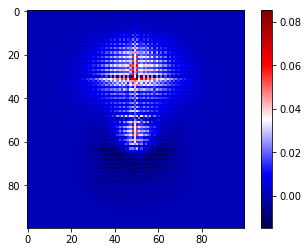

In [124]:
lrp_analyzer1 = innvestigate.create_analyzer("lrp.z", model_radius)
analysis = lrp_analyzer1.analyze(display)
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

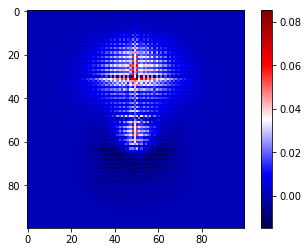

In [125]:
lrp_analyzer2 = innvestigate.create_analyzer("lrp.epsilon", model_radius)
analysis = lrp_analyzer2.analyze(display)
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()